# Presentation
1. background (Reddit, BSS, Selling our soul, etc.)
2. hypotheses (H1 & H2)
3. H1: preprocessing & code so far. 
4. H2: what we plan on doing 

## Importing Libraries

In [47]:
import logging
import os
import time
import warnings
import copy
import re
import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import nltk
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.matutils import corpus2csc, Sparse2Corpus
from gensim.models import LdaModel, LdaMulticore
from gensim.models.wrappers import LdaMallet #easier?
from gensim.models.coherencemodel import CoherenceModel #needed
from gensim.test.utils import datapath
from tmtoolkit.topicmod import evaluate, tm_lda
import NLP_visualization as NLP_vis
import clean_text as clean_fun
from sklearn.feature_extraction.text import CountVectorizer
import logging
import os
from gensim import corpora, models, utils
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load models, corpus & library

In [48]:
with open('C:\\Users\\95\\Dropbox\\MastersSem1\\NLP\\SmartHome\\SmartHomeNLP\\SmartHome\\models\\corpus.pkl', 'rb') as corpus:
    corpus = pickle.load(corpus)

with open('C:\\Users\\95\\Dropbox\\MastersSem1\\NLP\\SmartHome\\SmartHomeNLP\\SmartHome\\models\\dict.pkl', 'rb') as dictionary:
    dictionary = pickle.load(dictionary)

with open('C:\\Users\\95\\Dropbox\\MastersSem1\\NLP\\SmartHome\\SmartHomeNLP\\SmartHome\\models\\models_mallet_init.pkl', 'rb') as mallet_mods:
    mallet = pickle.load(mallet_mods)

In [49]:
## convert to gensim:
gensim_mods = {}
for i in mallet: 
    mod = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet[i])
    name = "{0}".format(i)
    gensim_mods[name] = mod

## Question 1: Do we find topics reflective of what BSS thought?

In [50]:
def plot_images(gensim_model, topics, columns = 5):
    
    total_img = topics
    import math
    rows = math.ceil(topics/columns)
    fig, axs = plt.subplots(rows, columns)
    
    for i in range(rows):
        cols_left = min(total_img, columns)
        if total_img < columns:
            for k in range(total_img,columns):
                fig.delaxes(axs[i, k])
        for j in range(cols_left):
                axs[i,j].imshow(WordCloud().fit_words(dict(gensim_mods["num_topics10"].show_topic((i*columns)+j, 100))))
                axs[i,j].axis("off")
                axs[i,j].set_title("Topic #" + str((i*columns)+j))
        total_img -= columns
    fig.tight_layout()
    fig.set_size_inches(15, 15)
    return fig

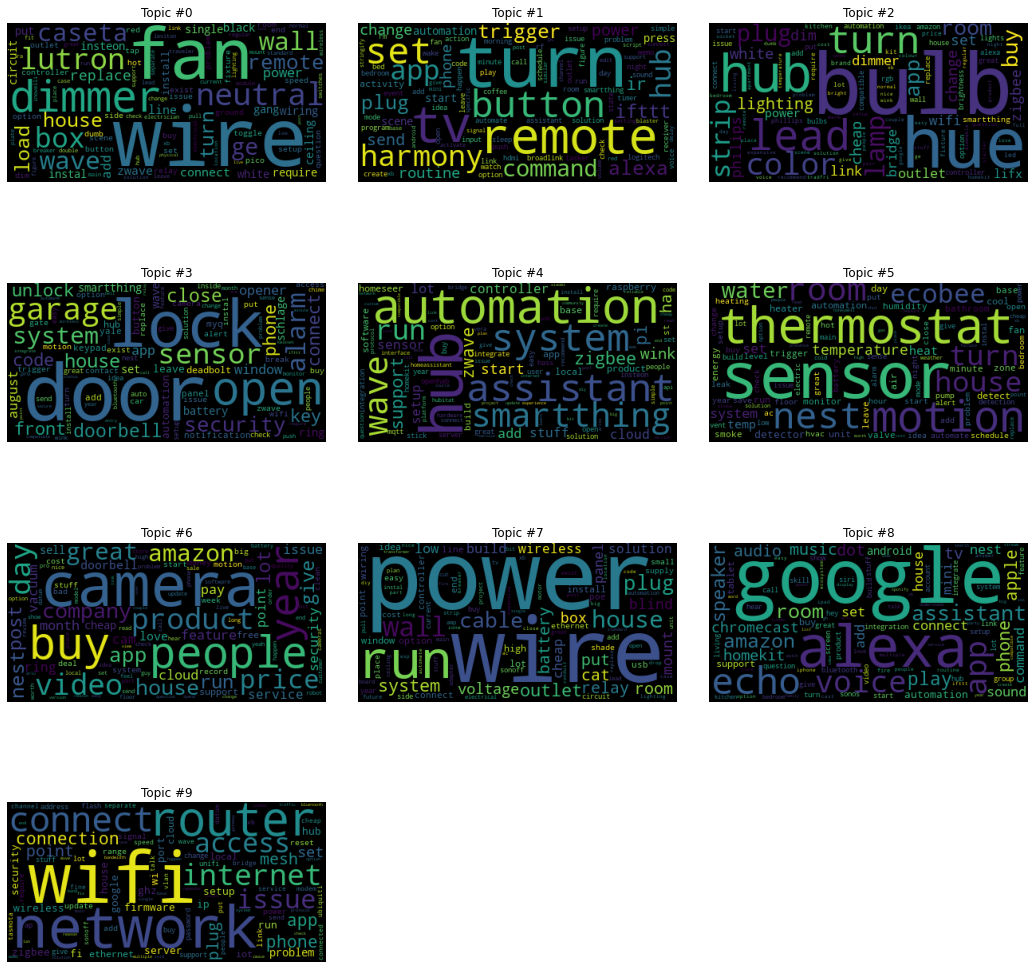

In [53]:
test = plot_images(gensim_mods["num_topics10"], 10, columns = 3)

In [84]:
## get security out: 
for i in gensim_mods: 
    print(f"{i}", gensim_mods[i].get_term_topics("security", minimum_probability=0.005))

num_topics5 [(4, 0.010340173162229483)]
num_topics10 [(3, 0.014134716325602193), (9, 0.005916892994843902)]
num_topics20 [(2, 0.009130427579594778), (3, 0.01550827692157997), (12, 0.019243569459421513), (19, 0.006139579591312059)]
num_topics50 [(17, 0.019022980337585347), (19, 0.008724457675020265), (35, 0.05818559982133788), (39, 0.016993868752612044)]


In [85]:
## 50 topics: these are actually quite interesting
liste = [17, 19, 35, 39]
for topic in liste: 
    print(gensim_mods["num_topics50"].show_topic(topic, 10))

[('internet', 0.06609376974598762), ('cloud', 0.06264194544240038), ('local', 0.04676933075770432), ('network', 0.04523117473957863), ('access', 0.03670632413207922), ('server', 0.030459821992742504), ('connection', 0.020165730894910725), ('security', 0.01902475131339026), ('service', 0.018898376992652236), ('ip', 0.016616417829611308)]
[('lock', 0.21567600852193217), ('door', 0.09644140183807673), ('unlock', 0.03033386348444287), ('key', 0.027877386914816907), ('august', 0.024436343998919946), ('schlage', 0.022384889705519172), ('code', 0.01893726106155351), ('deadbolt', 0.017778172921461905), ('connect', 0.01697471409708022), ('yale', 0.01426797986084357)]
[('alarm', 0.10933844904031557), ('system', 0.09809727020916326), ('security', 0.05818790435454982), ('panel', 0.03142342589239398), ('smoke', 0.027865595239260445), ('detector', 0.026001037496696654), ('sensor', 0.021449754817997636), ('house', 0.017020818447865793), ('monitor', 0.01660484099873739), ('door', 0.013962160733686346)

## Let us visualize weight vs. frequency of security in 50 topics

In [86]:
## (17, 0.019022980337585347), (19, 0.008724457675020265), (35, 0.05818559982133788), (39, 0.016993868752612044).
liste = [17, 19, 35, 39] ## contains most security weight. 
topics = []
for i in liste: 
    topics_tmp = gensim_mods["num_topics50"].show_topic(i, 15)
    element = (i, topics_tmp)
    topics.append(element)


In [64]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from collections import Counter

## import the data: 
#NLP_vis.vocabulary_freq_words(filter_dict_100K, True, 30)
#NLP_vis.vocabulary_descriptive(filter_dict_100K, corpus)

def vocabulary_frequency_words(dictionary):
    """
    Plot word frequency by the number of documents that contains it
    Input: gensim dictionary, direction, num. of words
    """
    
    dict_id2token = {id_:tok_ for (tok_, id_) in dictionary.token2id.items()}
    dict_token2freq = {dict_id2token[k]:v for (k,v) in dictionary.dfs.items()}

    words_df = pd.DataFrame.from_dict(dict_token2freq, orient="index", columns=["count"])
    
    return dict_token2freq

dict_token2freq = vocabulary_frequency_words(dictionary)


In [65]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

#topics = gensim_mods["num_topics50"].show_topics(4, formatted=False)

## 
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, dict_token2freq[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count']) 
df.head()
topic_ns = df.topic_id.unique()


c:\users\95\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\users\95\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\users\95\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\users\95\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


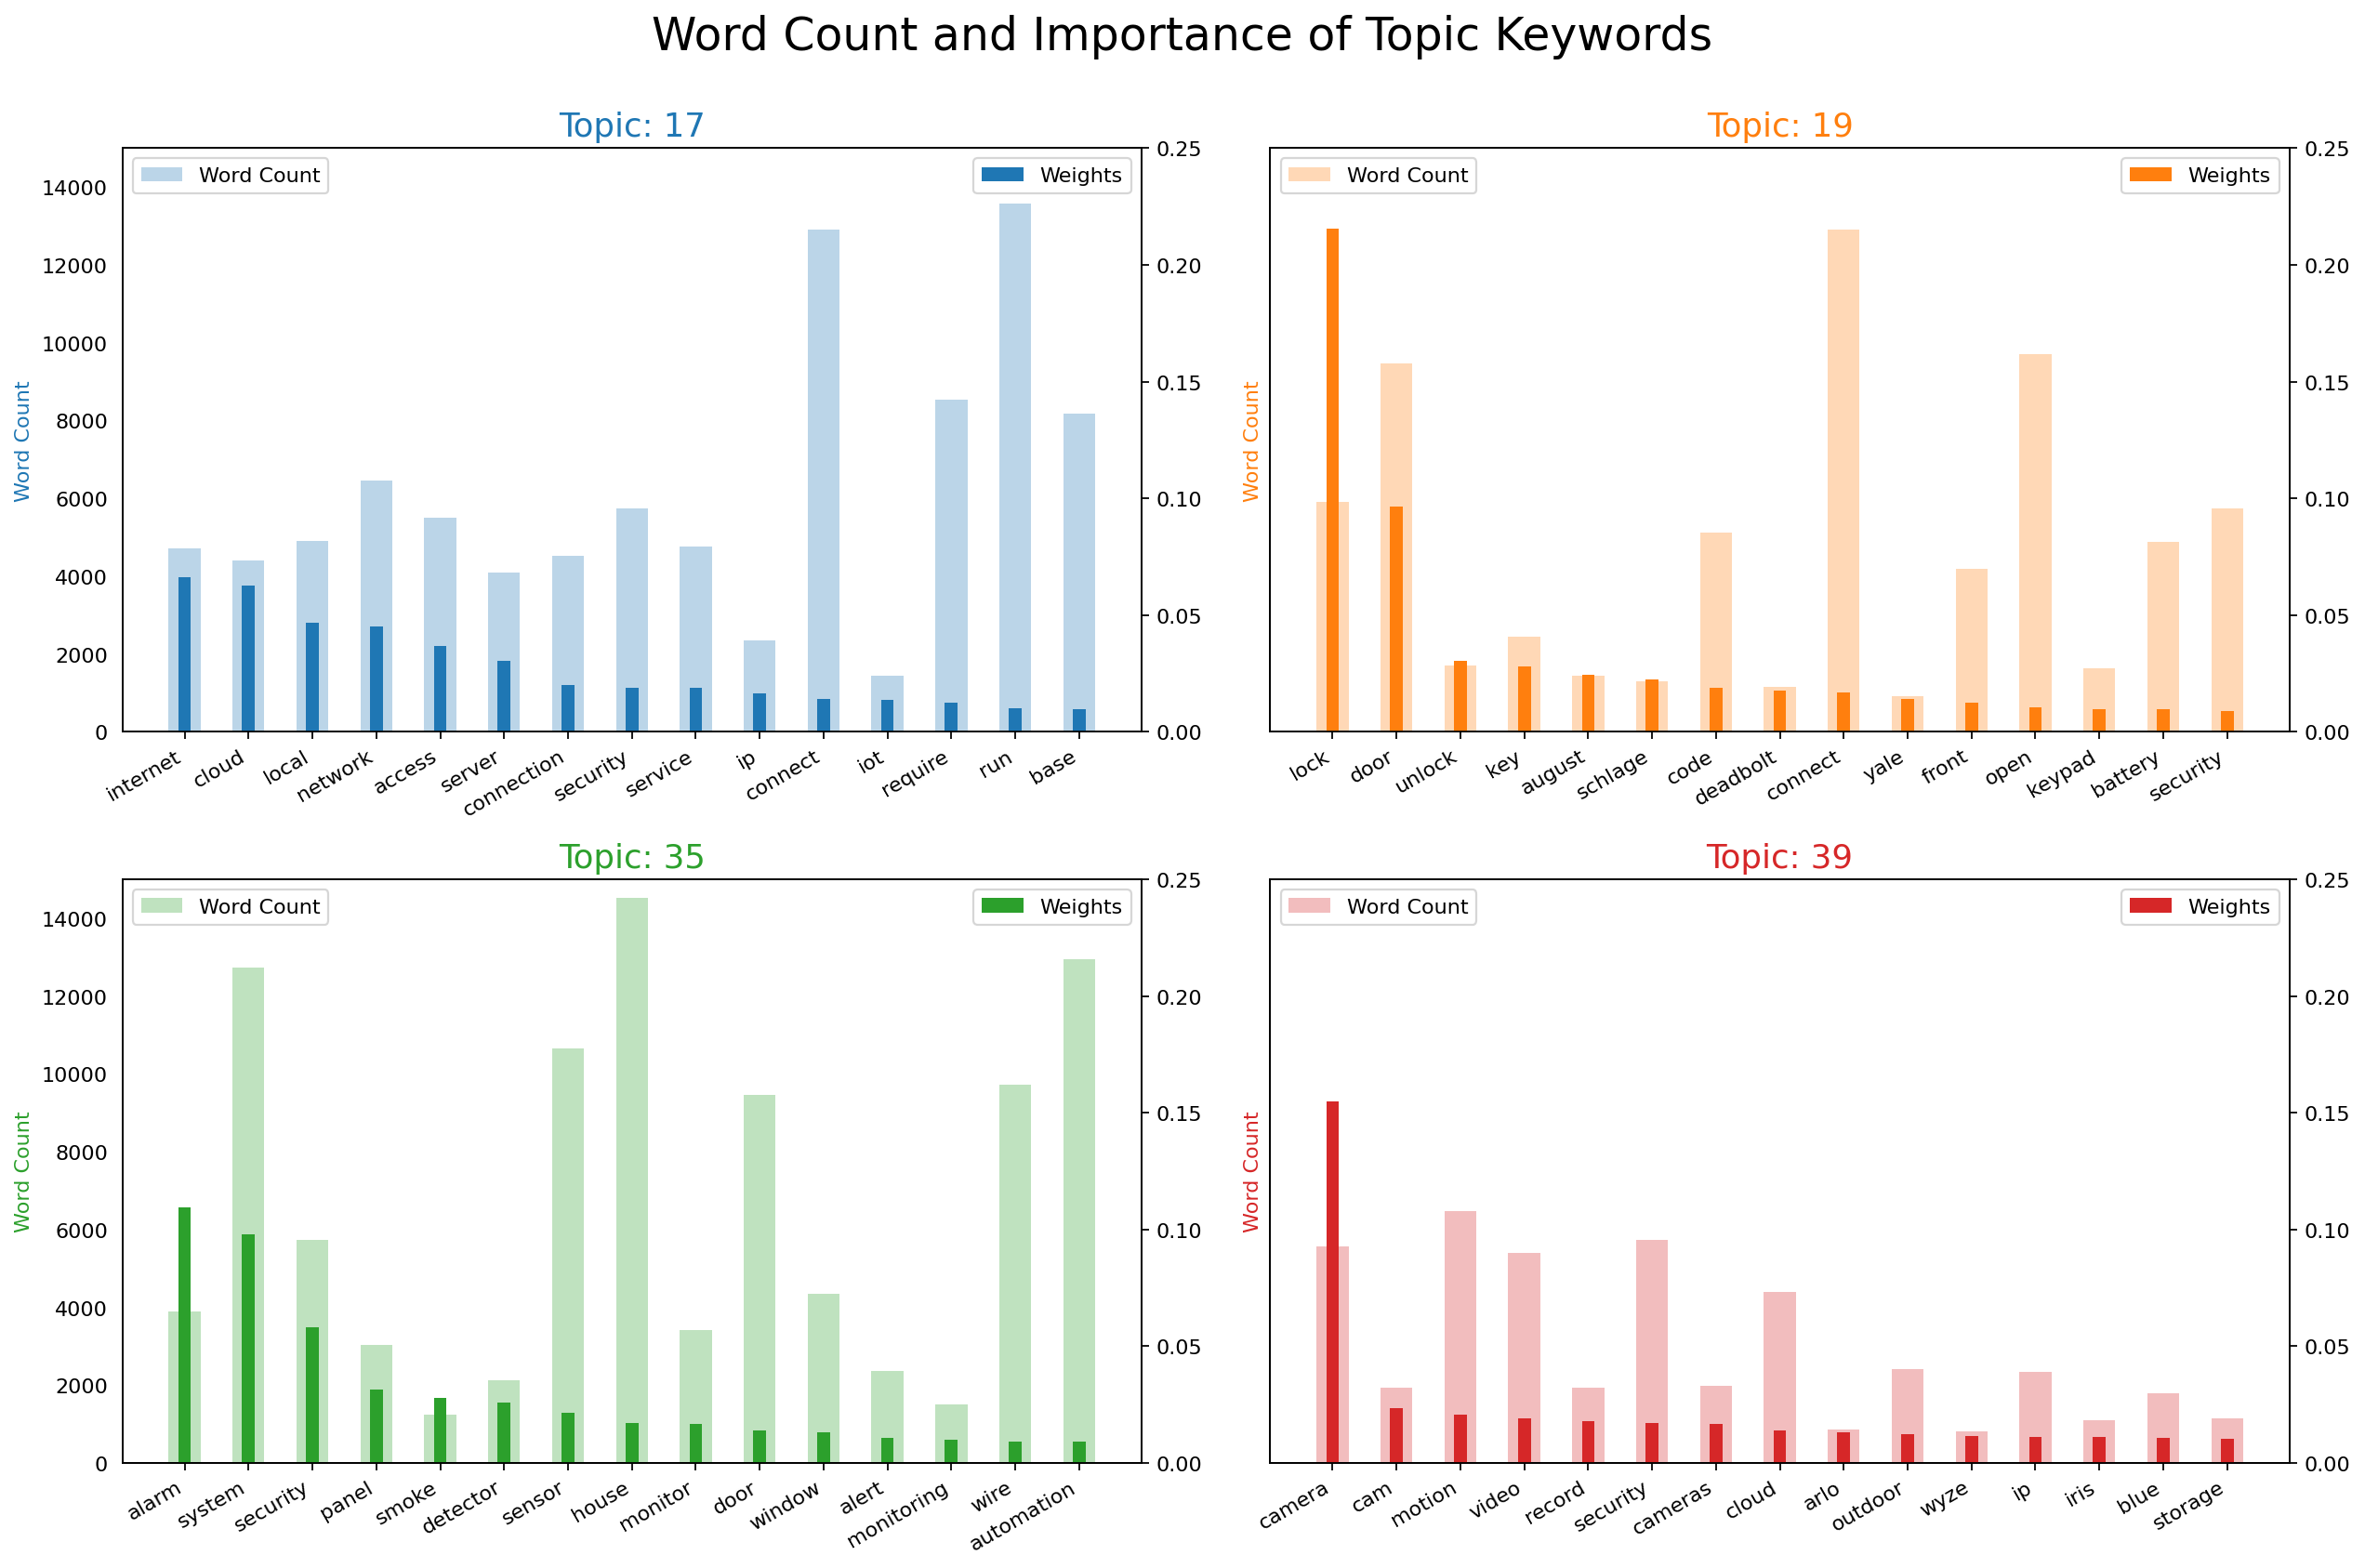

In [66]:
# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id== topic_ns[i], :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id== topic_ns[i], :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.25); ax.set_ylim(0, 15000)
    ax.set_title('Topic: ' + str(topic_ns[i]), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id== topic_ns[i], 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Who does not love a wordcloud

## pyLDAvis
takes a minute to run (actually a couple)

In [60]:
## Show some of the same things:
pyLDAvis.enable_notebook()
top20 = pyLDAvis.gensim.prepare(gensim_mods["num_topics20"], corpus, dictionary, sort_topics = False) ## so that it corresponds to gensim
pyLDAvis.display(top20)

c:\users\95\anaconda3\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
c:\users\95\anaconda3\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
c:\users\95\anaconda3\envs\nlp\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
